# Randomizing Load Curves

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime
import scipy
import seaborn as sns

In [2]:
df = pd.read_csv('../data/claes_test.csv', index_col=0, parse_dates=True)
df.drop(columns='V3', inplace=True)

In [3]:
# A function to copy a load profile with stochastic deviation
# from the original. The values varies according to a gaussian 
# distribution, with default and mu = 0, sigma = 0.1. The
# funtion returns a copy of the dataframe with the new column. 

def copy_load_stochastic(dataframe, column_name, sigma=0.1):
    
    min_prob, max_prob = -sigma, sigma
    prob_array = (max_prob - min_prob) * np.random.random_sample(size=dataframe.shape[0]) + min_prob
    new_col_name = column_name + '_stoch_copy'
    dataframe[new_col_name] = dataframe[column_name] + dataframe[column_name].mul(prob_array)
    
    return dataframe

In [4]:
df_with_copy = copy_load_stochastic(df, 'V4',sigma=0.5)

In [5]:
df_with_copy.head()

,Temperature,V2,V4,V5,V6,V7,V8,V9,V10,aggLoad,V4_stoch_copy
TimeDate,,,,,,,,,,,
2018-04-24 00:00:00,0.1,2.7,2.72,2.6,1.4,1.2,1.1,1.3,1.6,14.62,2.986744
2018-04-24 01:00:00,0.0,2.6,2.39,3.2,1.0,1.2,1.1,1.2,1.4,14.09,3.453055
2018-04-24 02:00:00,0.0,2.8,1.79,3.0,1.3,1.1,1.1,1.4,1.3,13.79,1.144303
2018-04-24 03:00:00,-0.1,2.6,1.78,3.0,1.3,1.2,1.1,1.9,1.1,13.98,1.852850
2018-04-24 04:00:00,-0.1,2.6,2.07,3.3,0.8,1.2,1.1,1.2,1.1,13.37,2.224315


In [6]:
df_with_copy['Year'] = df_with_copy.index.year
df_with_copy['Month'] = df_with_copy.index.month
df_with_copy['Weekday Name'] = df_with_copy.index.weekday_name

C:\Users\bas35\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


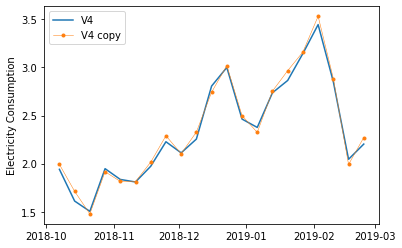

In [7]:
y1 = df_with_copy['V4'].resample('W').mean()
y2 = df_with_copy['V4_stoch_copy'].resample('W').mean()

fig, ax = plt.subplots()
ax.plot(y1.loc['2018-10':'2019-02'], label='V4')
ax.plot(y2.loc['2018-10':'2019-02'], marker='.', linestyle='-', linewidth=0.5, label='V4 copy')
ax.set_ylabel('Electricity Consumption')
ax.legend();

# Cleaning csv-files

In [8]:
#drop data before 2015-11-01 beacuse of null-values
#raw_data = raw_data['2015-11-01':]

In [10]:
# Function creating a (hopefully) cleaner dataframe from a csv-path.
# Printing of info is by default False and deleting zero columns True.

def clean_gudmund_csv(csv_path, prnt=False, del_zeros = True, interpolate = True):
    dataframe = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    drop_thresh_row = int(dataframe.shape[1]*0.80) #drop if ~20% of row is empty
    dataframe.dropna(axis=0, thresh = drop_thresh_row, inplace=True) #first row
    
    drop_thresh_col = int(dataframe.shape[0]*0.90) #drop if ~10% of column is empty
    dataframe.dropna(axis=1, thresh = drop_thresh_col, inplace=True) #then col
    
    if del_zeros:
        dataframe = dataframe.loc[:, (dataframe != 0).any(axis=0)] #delete columns with ALL zeros
        
    if interpolate:
        dataframe = dataframe.interpolate(method='polynomial', order=2)
    
    if prnt:
        start_time, end_time = dataframe.index[0], dataframe.index[-1]
        nan_indexes = dataframe.loc[pd.isnull(dataframe).any(1), :].index #not printing but maybe useful
        number_missing = len(nan_indexes) 
        df_size = (dataframe.shape[0])*(dataframe.shape[1])
        percent = round(number_missing/df_size *100,3) #% with 3 decimals
        print('Dataframe with consumption from {} load, ({} to {}).'.format(dataframe.shape[1],start_time,end_time))
        print('Out of {} values, {} is missing ({} %).'.format(df_size,number_missing, percent))
    
    return dataframe

In [11]:
df = clean_gudmund_csv('../data/new_houses_district_heating.csv', prnt=True)
df.head(20)

Dataframe with consumption from 46 load, (2015-10-31 00:00:00 to 2020-01-14 23:00:00).
Out of 1696848 values, 0 is missing (0.0 %).


,1,3,4,5,6,7,8,9,10,11,...,39,40,41,42,43,44,45,46,47,48
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-31 00:00:00,3.445,0.909,0.646,1.256,0.0,0.224,3.257,1.897,3.701,0.243,...,1.318,3.557,1.859,1.691,1.419,1.511,1.832,1.291,1.424,1.4890
2015-10-31 01:00:00,4.025,0.852,0.847,1.258,0.0,0.253,2.583,1.841,3.851,0.329,...,1.383,3.123,1.621,2.192,1.440,1.726,1.607,0.805,1.363,0.9975
2015-10-31 02:00:00,2.392,1.080,0.653,1.253,0.0,0.250,2.622,1.730,4.315,0.286,...,1.375,2.726,1.915,2.240,1.759,2.092,1.675,0.643,2.272,1.0275
2015-10-31 03:00:00,1.471,1.061,0.733,1.251,0.0,0.237,2.624,2.336,3.199,0.320,...,1.414,2.733,1.703,2.261,1.399,1.747,1.407,0.621,1.463,1.5515
2015-10-31 04:00:00,1.463,0.958,0.778,1.251,0.0,0.228,3.040,1.767,1.902,0.358,...,3.183,2.633,1.697,2.254,1.473,1.862,1.062,2.034,1.292,0.9125
2015-10-31 05:00:00,1.485,1.645,0.673,1.244,0.0,0.237,3.016,1.913,3.319,0.313,...,1.661,2.512,2.448,2.198,1.786,1.991,1.204,0.616,1.255,1.9410
2015-10-31 06:00:00,1.478,1.073,0.717,1.243,0.0,0.506,2.569,1.954,4.236,0.465,...,1.456,2.481,1.670,3.152,1.394,2.646,1.462,0.620,0.855,2.6150
2015-10-31 07:00:00,2.358,0.959,0.781,1.227,0.0,0.335,2.698,1.961,4.320,0.433,...,0.802,2.440,1.856,2.913,1.527,2.068,1.436,0.581,0.979,2.2340
2015-10-31 08:00:00,2.540,0.865,0.804,1.224,0.0,0.414,3.066,2.184,2.790,0.781,...,0.823,2.564,2.015,1.729,1.701,1.331,1.148,1.544,1.256,2.9050


In [ ]:
pd.date_range(start = '2015-10-31', end = '2020-01-14' ).difference(df.index)


In [ ]:
nan_indexes = df.loc[pd.isnull(df).any(1), :].index #not printing but maybe useful

In [ ]:
nan_indexes

In [9]:
print(len(df.iloc[:,4].tolist()))
print(np.count_nonzero(df.iloc[:,4].tolist()))

36888
36768


In [12]:
df = clean_gudmund_csv('../data/new_houses.csv', prnt=True)
df.head(20)

Dataframe with consumption from 46 load, (2015-10-31 00:00:00 to 2020-01-14 23:00:00).
Out of 1696848 values, 0 is missing (0.0 %).


,1,3,4,5,6,7,8,9,10,11,...,39,40,41,42,43,44,45,46,47,48
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-31 00:00:00,3.445,0.909,0.646,1.256,0.0,0.224,3.257,1.897,3.701,0.243,...,1.318,3.557,1.859,1.691,1.419,1.511,1.832,1.291,1.424,1.4890
2015-10-31 01:00:00,4.025,0.852,0.847,1.258,0.0,0.253,2.583,1.841,3.851,0.329,...,1.383,3.123,1.621,2.192,1.440,1.726,1.607,0.805,1.363,0.9975
2015-10-31 02:00:00,2.392,1.080,0.653,1.253,0.0,0.250,2.622,1.730,4.315,0.286,...,1.375,2.726,1.915,2.240,1.759,2.092,1.675,0.643,2.272,1.0275
2015-10-31 03:00:00,1.471,1.061,0.733,1.251,0.0,0.237,2.624,2.336,3.199,0.320,...,1.414,2.733,1.703,2.261,1.399,1.747,1.407,0.621,1.463,1.5515
2015-10-31 04:00:00,1.463,0.958,0.778,1.251,0.0,0.228,3.040,1.767,1.902,0.358,...,3.183,2.633,1.697,2.254,1.473,1.862,1.062,2.034,1.292,0.9125
2015-10-31 05:00:00,1.485,1.645,0.673,1.244,0.0,0.237,3.016,1.913,3.319,0.313,...,1.661,2.512,2.448,2.198,1.786,1.991,1.204,0.616,1.255,1.9410
2015-10-31 06:00:00,1.478,1.073,0.717,1.243,0.0,0.506,2.569,1.954,4.236,0.465,...,1.456,2.481,1.670,3.152,1.394,2.646,1.462,0.620,0.855,2.6150
2015-10-31 07:00:00,2.358,0.959,0.781,1.227,0.0,0.335,2.698,1.961,4.320,0.433,...,0.802,2.440,1.856,2.913,1.527,2.068,1.436,0.581,0.979,2.2340
2015-10-31 08:00:00,2.540,0.865,0.804,1.224,0.0,0.414,3.066,2.184,2.790,0.781,...,0.823,2.564,2.015,1.729,1.701,1.331,1.148,1.544,1.256,2.9050
